In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(42)

In [3]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}")

Using device cuda


In [4]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fmnist_small.csv')

In [5]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


In [6]:
df.shape

(6000, 785)

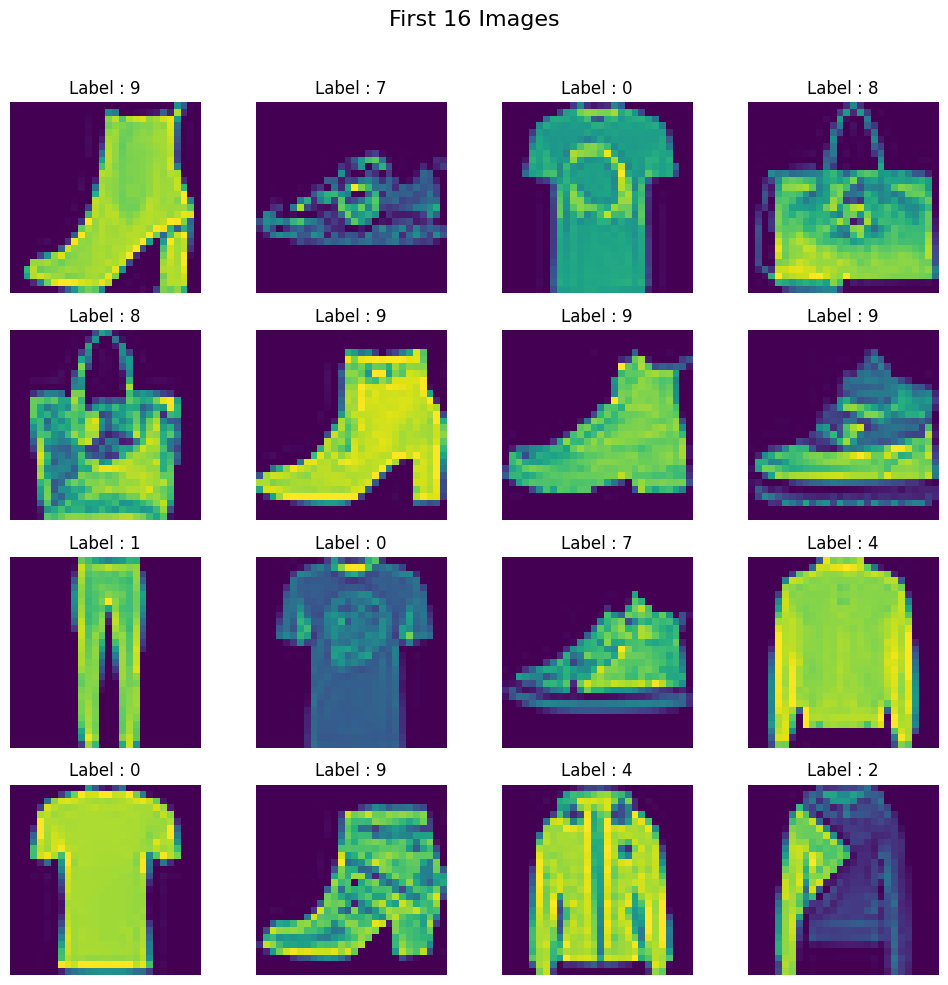

In [7]:
fig,axes=plt.subplots(4,4,figsize=(10,10))
fig.suptitle("First 16 Images",fontsize=16)

for i, ax in enumerate(axes.flat):
  img=df.iloc[i,1:].values.reshape(28,28)
  ax.imshow(img)
  ax.axis('off')
  ax.set_title(f"Label : {df.iloc[i,0]}")

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [8]:
X=df.iloc[:,1:].values
y=df.iloc[:,0].values

In [9]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [10]:
X_train=X_train/255.0
X_test=X_test/255.0

In [11]:
class CustomDataset(Dataset):
  def __init__(self,features,labels):
    self.features=torch.tensor(features,dtype=torch.float32)
    self.labels=torch.tensor(labels,dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self,index):
    return self.features[index],self.labels[index]


In [12]:
train_dataset=CustomDataset(X_train,y_train)
test_dataset=CustomDataset(X_test,y_test)

In [18]:
class MyNN(nn.Module):
  def __init__(self,input_dim,output_dim,num_hidden_layers,neurons_per_layer,dropout_rate):
    super().__init__()

    layers=[]

    for i in range(num_hidden_layers):
      layers.append(nn.Linear(input_dim,neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dropout_rate))
      input_dim=neurons_per_layer

    layers.append(nn.Linear(neurons_per_layer,output_dim))
    self.model=nn.Sequential(*layers)

  def forward(self,x):
    return self.model(x)


In [14]:
def objective(trial):
  num_hidden_layers=trial.suggest_int('num_hidden_layers',1,5)
  neurons_per_layer=trial.suggest_int('neurons_per_layer',8,128,step=8)
  epochs=trial.suggest_int("epochs",10,50,step=10)
  learning_rate=trial.suggest_float("learning_rate",1e-5,1e-1,log=True)
  dropout_rate=trial.suggest_float("dropout_rate",0.1,0.5,step=0.1)
  batch_size=trial.suggest_categorical("batch_size",[16,32,64,128])
  optimizer_name = trial.suggest_categorical("optimizer", ['Adam', 'SGD', 'RMSprop'])
  weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

  # model init
  input_dim = 784
  output_dim = 10

  model = MyNN(input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate)
  model.to(device)

  # optimizer selection
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4)

  if optimizer_name == 'Adam':
    optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif optimizer_name == 'SGD':
    optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
    optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  # training loop

  for epoch in range(epochs):

    for batch_features, batch_labels in train_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      # forward pass
      outputs = model(batch_features)

      # calculate loss
      loss = criterion(outputs, batch_labels)

      # back pass
      optimizer.zero_grad()
      loss.backward()

      # update grads
      optimizer.step()


  # evaluation
  model.eval()
  # evaluation on test data
  total = 0
  correct = 0

  with torch.no_grad():

    for batch_features, batch_labels in test_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      outputs = model(batch_features)

      _, predicted = torch.max(outputs, 1)

      total = total + batch_labels.shape[0]

      correct = correct + (predicted == batch_labels).sum().item()

    accuracy = correct/total

  return accuracy

In [15]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 14.6 MB/s eta 0:00:00


In [16]:
import optuna

study=optuna.create_study(direction='maximize')

[I 2025-03-23 08:44:47,935] A new study created in memory with name: no-name-e7148c10-7312-42a2-ad7d-5e30e53dfc45


In [19]:
study.optimize(objective,n_trials=10)

[I 2025-03-23 08:46:24,086] Trial 1 finished with value: 0.7716666666666666 and parameters: {'num_hidden_layers': 4, 'neurons_per_layer': 128, 'epochs': 30, 'learning_rate': 2.2011088446758272e-05, 'dropout_rate': 0.2, 'batch_size': 128, 'optimizer': 'SGD', 'weight_decay': 0.00046100392437957275}. Best is trial 1 with value: 0.7716666666666666.
[I 2025-03-23 08:46:33,565] Trial 2 finished with value: 0.8291666666666667 and parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 80, 'epochs': 20, 'learning_rate': 2.6125937468949882e-05, 'dropout_rate': 0.30000000000000004, 'batch_size': 16, 'optimizer': 'SGD', 'weight_decay': 7.316806738690544e-05}. Best is trial 2 with value: 0.8291666666666667.
[I 2025-03-23 08:46:34,916] Trial 3 finished with value: 0.7925 and parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 8, 'epochs': 10, 'learning_rate': 0.000141082463162854, 'dropout_rate': 0.2, 'batch_size': 64, 'optimizer': 'Adam', 'weight_decay': 0.000577239707681288}. Best is tria

In [20]:
study.best_params

{'num_hidden_layers': 4,
 'neurons_per_layer': 80,
 'epochs': 40,
 'learning_rate': 9.150557530703678e-05,
 'dropout_rate': 0.4,
 'batch_size': 64,
 'optimizer': 'RMSprop',
 'weight_decay': 6.971646308321963e-05}

In [22]:
study.best_value

0.8308333333333333